In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import locale
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
from tensorflow.python.keras.layers.core import Activation
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import backend


In [52]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE, report_tensor_allocations_upon_oom = True)
run_metadata = tf.RunMetadata()


In [80]:
data=pd.read_csv("training_normalized.csv")

In [81]:
data.head(200)

xline  N.Avg Amp  Fpeak  Fmax_pick
0     4000   0.434286      0  84.947599
1     4000   0.434286      0  84.942648
2     4000   0.434286      0  84.937697
3     4000   0.434286      0  84.932745
4     4000   0.434286      0  84.927794
..     ...        ...    ...        ...
195   4000   0.535238     54  83.573670
196   4000   0.323810     62  81.140337
197   4000   0.340952     62  78.707004
198   4000   0.516190     62  76.273670
199   4000   0.571429     42  73.840337

[200 rows x 4 columns]

In [82]:
data.describe(include='all')

xline     N.Avg Amp         Fpeak     Fmax_pick
count  49900.000000  49900.000000  49900.000000  49900.000000
mean    4248.000000      0.454592     26.503687     51.260601
std      147.974453      0.107874     16.953545     17.488284
min     4000.000000      0.000000      0.000000     15.816121
25%     4120.000000      0.405714     16.000000     36.583455
50%     4245.000000      0.434286     24.000000     48.520013
75%     4380.000000      0.502857     38.000000     66.598056
max     4500.000000      1.000000    124.000000     86.654824

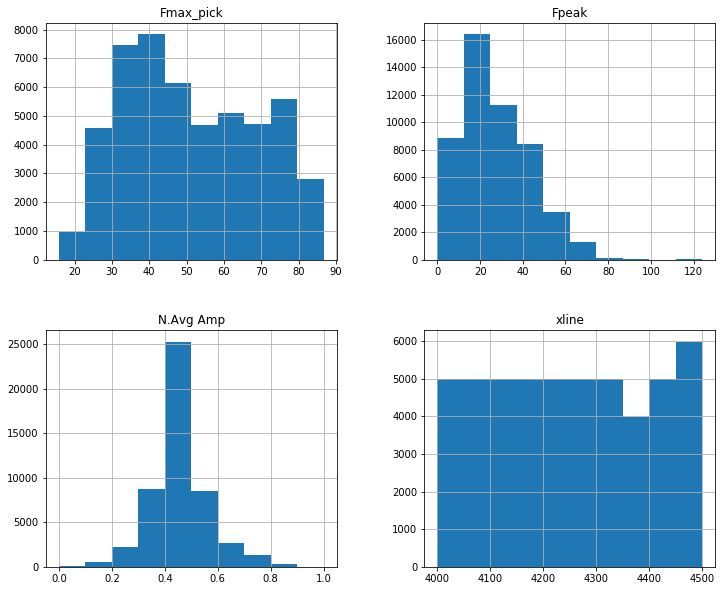

In [83]:

data.hist(figsize = (12,10))
plt.show()

sns.pairplot(data)

In [84]:
C_mat = data.corr()
fig = plt.figure(figsize = (15,15))

sns.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [102]:
dataset=data.to_numpy()

x=dataset[:,0:3]
y=dataset[:,3]

x_base=x.reshape(998,50,3)
y_base=y.reshape(998,50)


#print(x_base)
#print(y_base)

# Generate dummy data
#x_base = np.random.random((1000, 100, 3))
#y_base = np.random.random((1000, 100))

#s0, s1, s2= y_base.shape[0], y_base.shape[1], y_base.shape[2]
#y_base = y_base.reshape(s0, s1*s2)
scaler_y = MinMaxScaler()
scaler_y.fit(y_base)
yscale=scaler_y.transform(y_base)
#yscale = yscale.reshape(s0, s1, s2)
#y_base = y_base.reshape(s0, s1, s2)

xs0, xs1, xs2= x_base.shape[0], x_base.shape[1], x_base.shape[2]
x_base = x_base.reshape(xs0 * xs1, xs2)
scaler_x = MinMaxScaler()
scaler_x.fit(x_base)
xscale=scaler_x.transform(x_base)
xscale = xscale.reshape(xs0, xs1, xs2)
x_base = x_base.reshape(xs0, xs1, xs2)


In [107]:
def create_cnn1():

    model = Sequential()

    model.add(Conv1D(50, 5, activation='relu', input_shape=(50, 3)))
    model.add(Conv1D(50, 5, activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(80, 5, activation='relu'))
    model.add(Conv1D(80, 5, activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='linear'))
    
    return model


def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))


In [109]:
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size=0.2)

#s0, s1, s2= y_train.shape[0], y_train.shape[1]
#y_train = y_train.reshape(s0, s1*s2)
#xs0, xs1, xs2= y_test.shape[0], y_test.shape[1]
#y_test = y_test.reshape(xs0, xs1*xs2)




model = create_cnn1()
print(model.summary())

opt = optimizers.adam(lr=0.001, decay=1e-3/200)
#opt = optimizers.sgd(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='mse', optimizer=opt, metrics=['mae','accuracy'])
#model.compile(loss='mse', optimizer=opt, metrics=['mse', 'mae', 'mape'])
model.compile(loss='mse', optimizer=opt, metrics=[rmse])


checkpoint_name = 'Best_Weights.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

#history = model.fit(X_train, y_train, epochs=150, batch_size=32,  verbose=1, validation_split=0.2)
history = model.fit(X_train, y_train, epochs=100, batch_size=32,  verbose=2, validation_data=(X_test,y_test),callbacks=callbacks_list)

# plot metrics
plt.plot(history.history['rmse'])
#plt.plot(history.history['mean_squared_error'])

plt.show()

print(history.history.keys())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 46, 50)            800       
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 42, 50)            12550     
_________________________________________________________________
batch_normalization_19 (Batc (None, 42, 50)            200       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 14, 50)            0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 10, 80)            20080     
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 6, 80)             32080     
_________________________________________________________________
batch_normalization_20 (Batc (None, 6, 80)           


Epoch 00037: val_loss improved from 0.02050 to 0.01978, saving model to Best_Weights.hdf5
798/798 - 0s - loss: 0.0275 - rmse: 0.1438 - val_loss: 0.0198 - val_rmse: 0.1174
Epoch 38/100

Epoch 00038: val_loss did not improve from 0.01978
798/798 - 0s - loss: 0.0244 - rmse: 0.1360 - val_loss: 0.0210 - val_rmse: 0.1227
Epoch 39/100

Epoch 00039: val_loss did not improve from 0.01978
798/798 - 0s - loss: 0.0248 - rmse: 0.1362 - val_loss: 0.0210 - val_rmse: 0.1207
Epoch 40/100

Epoch 00040: val_loss improved from 0.01978 to 0.01967, saving model to Best_Weights.hdf5
798/798 - 0s - loss: 0.0252 - rmse: 0.1370 - val_loss: 0.0197 - val_rmse: 0.1165
Epoch 41/100

Epoch 00041: val_loss did not improve from 0.01967
798/798 - 0s - loss: 0.0269 - rmse: 0.1418 - val_loss: 0.0241 - val_rmse: 0.1317
Epoch 42/100

Epoch 00042: val_loss did not improve from 0.01967
798/798 - 0s - loss: 0.0252 - rmse: 0.1376 - val_loss: 0.0200 - val_rmse: 0.1197
Epoch 43/100

Epoch 00043: val_loss did not improve from 0.

Epoch 92/100

Epoch 00092: val_loss did not improve from 0.01819
798/798 - 0s - loss: 0.0175 - rmse: 0.1137 - val_loss: 0.0195 - val_rmse: 0.1171
Epoch 93/100

Epoch 00093: val_loss did not improve from 0.01819
798/798 - 0s - loss: 0.0164 - rmse: 0.1092 - val_loss: 0.0243 - val_rmse: 0.1294
Epoch 94/100

Epoch 00094: val_loss did not improve from 0.01819
798/798 - 0s - loss: 0.0163 - rmse: 0.1085 - val_loss: 0.0213 - val_rmse: 0.1230
Epoch 95/100

Epoch 00095: val_loss did not improve from 0.01819
798/798 - 0s - loss: 0.0166 - rmse: 0.1108 - val_loss: 0.0184 - val_rmse: 0.1147
Epoch 96/100

Epoch 00096: val_loss did not improve from 0.01819
798/798 - 0s - loss: 0.0178 - rmse: 0.1137 - val_loss: 0.0195 - val_rmse: 0.1170
Epoch 97/100

Epoch 00097: val_loss did not improve from 0.01819
798/798 - 0s - loss: 0.0167 - rmse: 0.1110 - val_loss: 0.0194 - val_rmse: 0.1180
Epoch 98/100

Epoch 00098: val_loss did not improve from 0.01819
798/798 - 0s - loss: 0.0170 - rmse: 0.1120 - val_loss: 0.01

dict_keys(['loss', 'rmse', 'val_loss', 'val_rmse'])


In [110]:
# Load wights file of the best model :
#weights_file = 'Weights-149--0.01664.hdf5' # choose the best checkpoint 
weights_file = 'Best_Weights.hdf5'
model.load_weights(weights_file) # load it
#model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
model.compile(loss='mse', optimizer=opt, metrics=[rmse])

In [111]:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

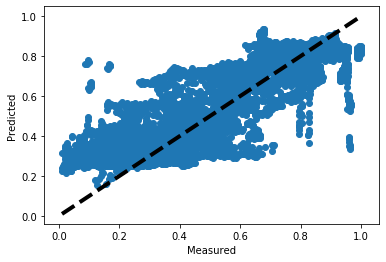

In [112]:
y_pred= model.predict(X_test) 
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [114]:
from sklearn.metrics import r2_score

In [115]:
r2_score(y_test,y_pred)

0.7521672722150029

In [113]:
Xnew = np.array([[40, 0, 26]])
Xnew= scaler_x.transform(Xnew)
ynew= model.predict(Xnew)
#invert normalize
ynew = scaler_y.inverse_transform(ynew) 
Xnew = scaler_x.inverse_transform(Xnew)
print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))

ValueError: Error when checking input: expected conv1d_34_input to have 3 dimensions, but got array with shape (1, 3)